In [29]:
import numpy as np
import pandas as pd
import yaml
import scipy as sp
import seaborn as sns

from copy import deepcopy
from pathlib import Path
from typing import Literal
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from assistive_arm.utils.data_preprocessing import read_headers, smooth_dataframe, interpolate_dataframe
from assistive_arm.utils.emg_processing import filter_emg

np.set_printoptions(precision=3, suppress=True)
sns.set_theme(style="darkgrid")

In [2]:
def print_dict_structure(d, indent=0):
    for key, value in d.items():
        print(' ' * indent + f"{key}: {type(value)}")
        if isinstance(value, dict):
            print_dict_structure(value, indent + 4)

In [3]:
subject = "MIH02"
subject_dir = Path(f"../subject_logs/subject_{subject}")
session_dir = subject_dir / "December_20"

angle_calibration_path = session_dir / "device_height_calibration.yaml"
emg_dir = session_dir / "EMG"

# Read EMG file to extract configuration
emg_file = emg_dir / "assist_0001_emg.tsv" # 2 on treadmill room, 3 on track room
emg_config = dict()

relevant_headers = ["FREQUENCY", "CHANNEL_NAMES"]


emg_config["MAPPING"] = {
    "Trigno Avanti Duo Mini1_EMG BLUE": "RIGHT_VM",
    "Trigno Avanti Duo Mini1_EMG YELLOW": "RIGHT_RF",
    "Trigno Avanti Duo Mini2_EMG BLUE": "LEFT_VM",
    "Trigno Avanti Duo Mini2_EMG YELLOW": "LEFT_RF",
    "Trigno Avanti Duo Mini3_EMG BLUE": "RIGHT_BF_1",
    "Trigno Avanti Duo Mini3_EMG YELLOW": "RIGHT_BF_2",
    "Trigno Avanti Duo Mini4_EMG BLUE": "LEFT_BF_1",
    "Trigno Avanti Duo Mini4_EMG YELLOW": "LEFT_BF_2",
}

# emg_config["MAPPING"] = {"Trigno Avanti Duo Mini1_EMG 2": "EMG_RIGHT", "Trigno Avanti Duo Mini2_EMG 1": "EMG_LEFT"}

for header in read_headers(emg_file, 13, delimiter="\t"):
    if header[0] in relevant_headers:
        if header[0] == "FREQUENCY":
            emg_config[header[0]] = float(header[1])
        else:
            emg_config[header[0]] = header[1:]

with open(session_dir / "emg_config.yaml", "w") as f:
    yaml.dump(emg_config, f)

with open(angle_calibration_path, 'r') as f:
    angle_calibration = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
relevant_cols = ["TIME"] + list(emg_config["MAPPING"].keys())

session_data = {}
session_data["MVIC"] = {}
session_data["MVIC"]["LEFT"] = None
session_data["MVIC"]["RIGHT"] = None

data_dict = {"EMG": [],
             "MOTOR_DATA": [],
             "MARKER_DATA": []}

session_data["UNPOWERED"] = {}
session_data["ASSISTED"] = {}
session_data["UNPOWERED"]["BEFORE"] = deepcopy(data_dict)
session_data["UNPOWERED"]["AFTER"] = deepcopy(data_dict)

# Load all session data
profile_to_num = {}

# Handle first motor data
for file_path in sorted(session_dir.iterdir()):
    if file_path.suffix == ".csv":
        if "unpowered" in file_path.stem:
            df = pd.read_csv(file_path, index_col="time")
            n = int(file_path.stem.split("_")[1])
            if n <= 5:
                session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"].append(df)
            else:
                session_data["UNPOWERED"]["AFTER"]["MOTOR_DATA"].append(df)
        elif "assist" in file_path.stem:
            df = pd.read_csv(file_path, skiprows=2, index_col="time")

            profile_info = read_headers(file_path=file_path, rows=2, delimiter=",")
            time = int(profile_info[0][1])
            force = int(profile_info[1][1])

            profile = f"peak_{time}%_{force}N"

            if profile not in profile_to_num.keys():
                profile_to_num[profile] = []

            num = int(file_path.stem.split("_")[-1])
            profile_to_num[profile].append(num)

            if profile not in session_data["ASSISTED"].keys():
                session_data["ASSISTED"][profile] = deepcopy(data_dict)

            session_data["ASSISTED"][profile]["MOTOR_DATA"].append(df)

# Handle second EMG data
for file_path in sorted(emg_dir.iterdir()):
    if file_path.suffix == ".tsv":
        if "unpowered" in file_path.stem:
            n = int(file_path.stem.split("_")[1])

            if "marker" in file_path.stem:
                # Convert mm to meters
                df = pd.read_csv(file_path, sep="\t", skiprows=11, usecols=["Time", "Hip Left Z", "Hip Right Z"], index_col="Time") / 1000
                if n <= 5:
                    session_data["UNPOWERED"]["BEFORE"]["MARKER_DATA"].append(df)
                else:
                    session_data["UNPOWERED"]["AFTER"]["MARKER_DATA"].append(df)
            else:
                df = pd.read_csv(file_path, sep="\t", skiprows=13, usecols=relevant_cols, index_col="TIME")
                df.rename(columns=emg_config["MAPPING"], inplace=True)

                if n <= 5:
                    session_data["UNPOWERED"]["BEFORE"]["EMG"].append(df)
                else:
                    session_data["UNPOWERED"]["AFTER"]["EMG"].append(df)

        elif "assist" in file_path.stem:
            if "marker" in file_path.stem:
                df = pd.read_csv(file_path, sep="\t", skiprows=11, usecols=["Time", "Hip Left Z", "Hip Right Z"], index_col="Time") / 1000
                data_type = "MARKER_DATA"
            else:
                df = pd.read_csv(file_path, sep="\t", skiprows=13, usecols=relevant_cols, index_col="TIME")
                df.rename(columns=emg_config["MAPPING"], inplace=True)
                data_type = "EMG"
                
            num = int(file_path.stem.split("_")[1])

            for profile, nums in profile_to_num.items():
                if num in nums:
                    session_data["ASSISTED"][profile][data_type].append(df)
                    
        elif "MVIC" in file_path.stem:
            df = pd.read_csv(file_path, sep="\t", skiprows=13, usecols=relevant_cols, index_col="TIME")
            df.rename(columns=emg_config["MAPPING"], inplace=True)
            
            side = "LEFT" if "Left" in file_path.stem else "RIGHT"
            side_prefix = "LEFT_" if side == "LEFT" else "RIGHT_"

            if "BF" in file_path.name:  # If it's the BF file
                bf_col = [col for col in df.columns if side_prefix + "BF" in col]  # Adjust this if your naming convention is different
                df = df[bf_col]
            elif "RF" in file_path.name or "VM" in file_path.name:  # If it's the RF or VM file
                rf_vm_cols = [col for col in df.columns if any(sub in col for sub in [side_prefix + "RF", side_prefix + "VM"])]  # Adjust this if your naming convention is different
                df = df[rf_vm_cols]
            
            if session_data["MVIC"][side] is not None:
                # Merge the new data with the existing data
                session_data["MVIC"][side] = pd.merge(session_data["MVIC"][side], df, left_index=True, right_index=True, how='outer')
            else:
                # Initialize with the new data
                session_data["MVIC"][side] = df

In [5]:
def plot_muscle_emg(title: str, target_muscle: Literal["RF", "VM", "BF"], unfiltered_dfs: list[pd.DataFrame], filtered_dfs: list[pd.DataFrame], freq: float=6):
    """ Plot EMG relevant for a given muscle (untiltered vs. filtered)

    Args:
        title (str): plot title
        target_muscle (Literal["RF", "VM", "BF"]): muscle we want to plot
        unfiltered_dfs (list[pd.DataFrame]): list of unfiltered dataframes
        filtered_dfs (list[pd.DataFrame]): list of filtered dataframes
        freq (float, optional): Filter frequency. Defaults to 6.

    Raises:
        ValueError: _description_
    """
    if len(unfiltered_dfs) != len(filtered_dfs):
        raise ValueError("The number of unfiltered and filtered DataFrames must be the same.")

    num_rows = len(unfiltered_dfs) - 3
    single_row = num_rows == 1

    fig, axs = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4 if not single_row else 5))
    fig.suptitle(title, fontsize=16)
    
    axs = axs.reshape(num_rows, -1)  # Ensure axs is always 2D

    for i in range(num_rows):
        time_unfiltered = unfiltered_dfs[i].index.values
        time_filtered = filtered_dfs[i].index.values

        for j in range(4):
            axs[i, j].set_title(f'Iteration {i+1}, {"Filtered" if j % 2 else "Unfiltered"}, {f"RIGHT_{target_muscle}" if j > 1 else f"LEFT_{target_muscle}"}')
            axs[i, j].grid(True)

            if j == 0 or j == 2:
                axs[i, j].set_ylabel("EMG signal (mV)")
            axs[i, j].set_xlabel("Time (s)")

        axs[i, 0].plot(time_unfiltered, unfiltered_dfs[i][f'LEFT_{target_muscle}'], label=f"Unfiltered LEFT_{target_muscle}")
        axs[i, 1].plot(time_filtered, filtered_dfs[i][f'LEFT_{target_muscle}'], label=f"Filtered LEFT_{target_muscle}")
        axs[i, 2].plot(time_unfiltered, unfiltered_dfs[i][f'RIGHT_{target_muscle}'], label=f"Unfiltered RIGHT_{target_muscle}")
        axs[i, 3].plot(time_filtered, filtered_dfs[i][f'RIGHT_{target_muscle}'], label=f"Filtered RIGHT_{target_muscle}")

    plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
    plt.show()
    


### Filter all EMG data

In [6]:
filtered_session_data = deepcopy(session_data)

In [7]:
filtered_session_data["MVIC"]["LEFT"], _ = filter_emg(session_data["MVIC"]["LEFT"], sfreq=emg_config["FREQUENCY"])
filtered_session_data["MVIC"]["RIGHT"], _ = filter_emg(session_data["MVIC"]["RIGHT"], sfreq=emg_config["FREQUENCY"])

for profile, emg_data in session_data["ASSISTED"].items():
    for i, emg_df in enumerate(session_data["ASSISTED"][profile]["EMG"]):
        filtered_session_data["ASSISTED"][profile]["EMG"][i], _ = filter_emg(emg_df, sfreq=emg_config["FREQUENCY"])

for unpow_key in session_data["UNPOWERED"].keys():
    for i, emg_df in enumerate(session_data["UNPOWERED"][unpow_key]["EMG"]):
        filtered_session_data["UNPOWERED"][unpow_key]["EMG"][i], _ = filter_emg(emg_df, sfreq=emg_config["FREQUENCY"])

### Plot MAX Activation data

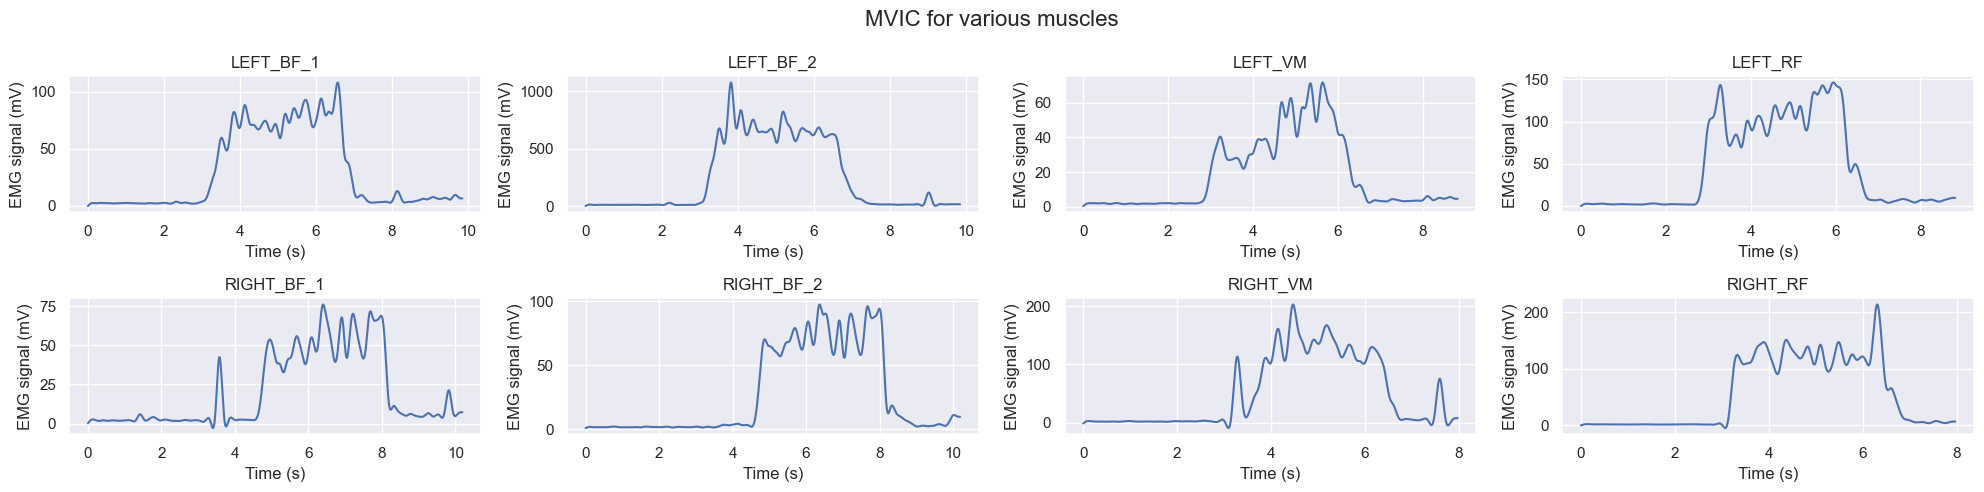

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(20, 5))
fig.suptitle("MVIC for various muscles", fontsize=16)

for i, side in enumerate(filtered_session_data["MVIC"].keys()):
    for j, col in enumerate(filtered_session_data["MVIC"][side].columns):
        axs[i, j].plot(filtered_session_data["MVIC"][side].index, filtered_session_data["MVIC"][side][col])
        axs[i, j].set_title(f"{col}")
        axs[i, j].set_xlabel("Time (s)")
        axs[i, j].set_ylabel("EMG signal (mV)")
        axs[i, j].grid(True)
plt.tight_layout()

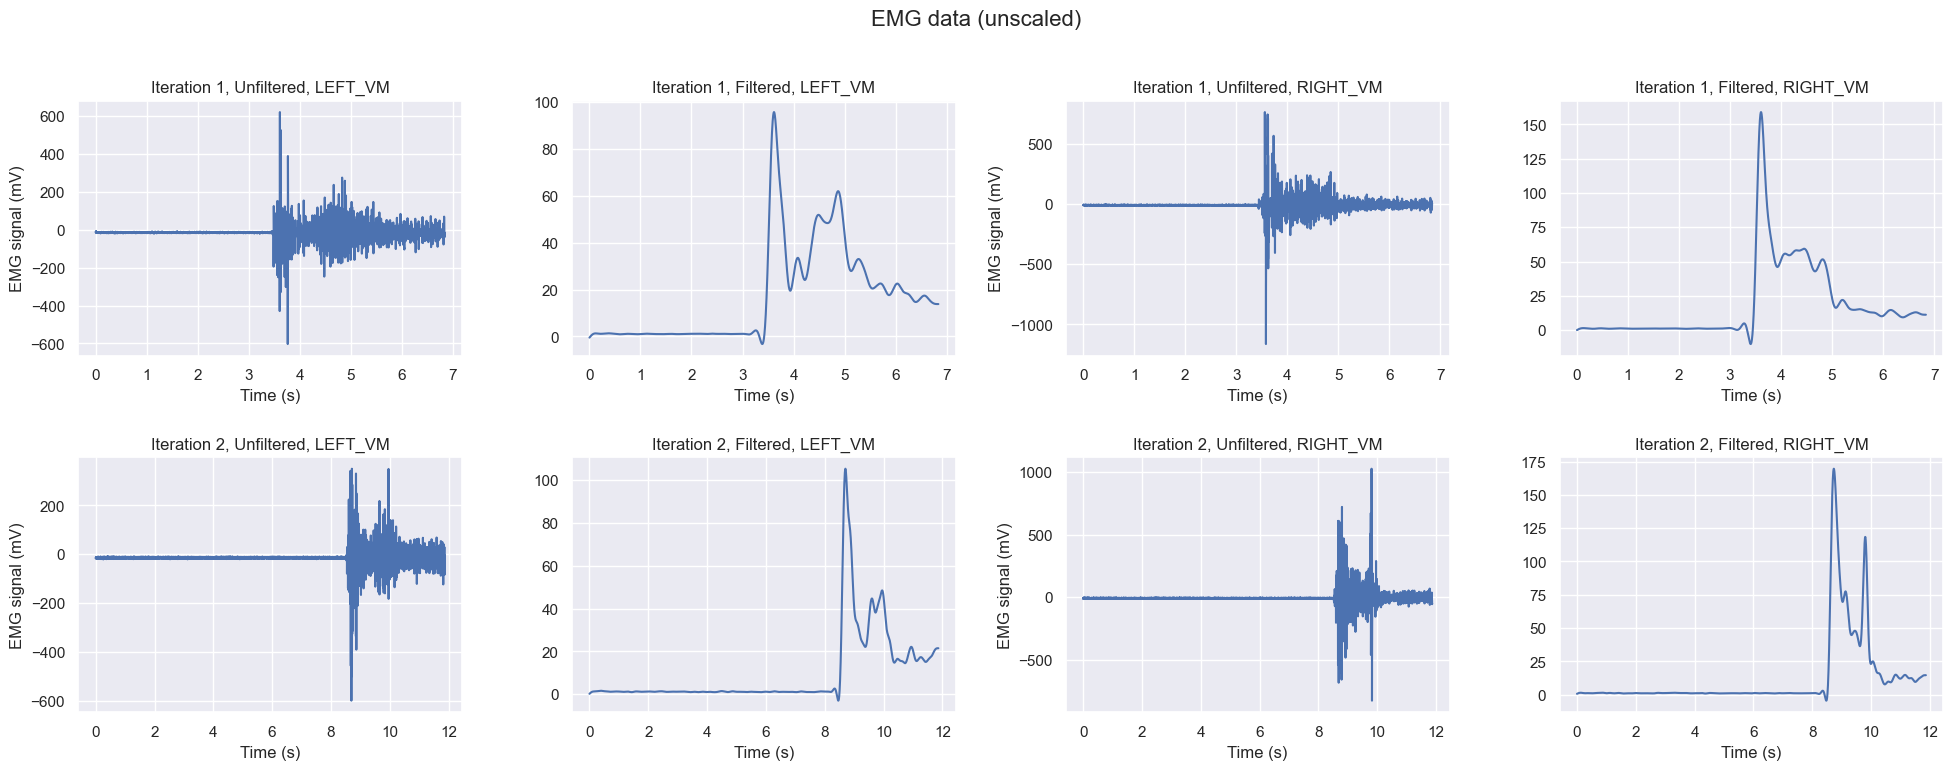

In [9]:
plot_muscle_emg(title="EMG data (unscaled)", 
                target_muscle="VM",
                unfiltered_dfs=session_data["ASSISTED"]["peak_27%_62N"]["EMG"],
                filtered_dfs=filtered_session_data["ASSISTED"]["peak_27%_62N"]["EMG"], 
                freq=emg_config["FREQUENCY"])

### Scale data based on MVIC

In [10]:
left_mvic_cols = list(filtered_session_data["MVIC"]["LEFT"].columns)
right_mvic_cols = list(filtered_session_data["MVIC"]["RIGHT"].columns)

max_left = list(filtered_session_data["MVIC"]["LEFT"].max())
max_right = list(filtered_session_data["MVIC"]["RIGHT"].max())

# Create dataframe containing the max values for each muscle, should be 1 row
mvic_df = pd.DataFrame(data=[max_left + max_right], columns=left_mvic_cols + right_mvic_cols)
mvic_df = mvic_df[session_data["UNPOWERED"]["BEFORE"]["EMG"][0].columns]

In [11]:
_, freq = filter_emg(session_data["MVIC"]["LEFT"], sfreq=emg_config["FREQUENCY"])

In [12]:
for profile in filtered_session_data["ASSISTED"].keys():
    for i, filtered_emg in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
        filtered_emg /= mvic_df.iloc[0]
for t_unpowered in filtered_session_data["UNPOWERED"].keys():
    for i, unpowered_df in enumerate(filtered_session_data["UNPOWERED"][t_unpowered]["EMG"]):
        unpowered_df /= mvic_df.iloc[0]

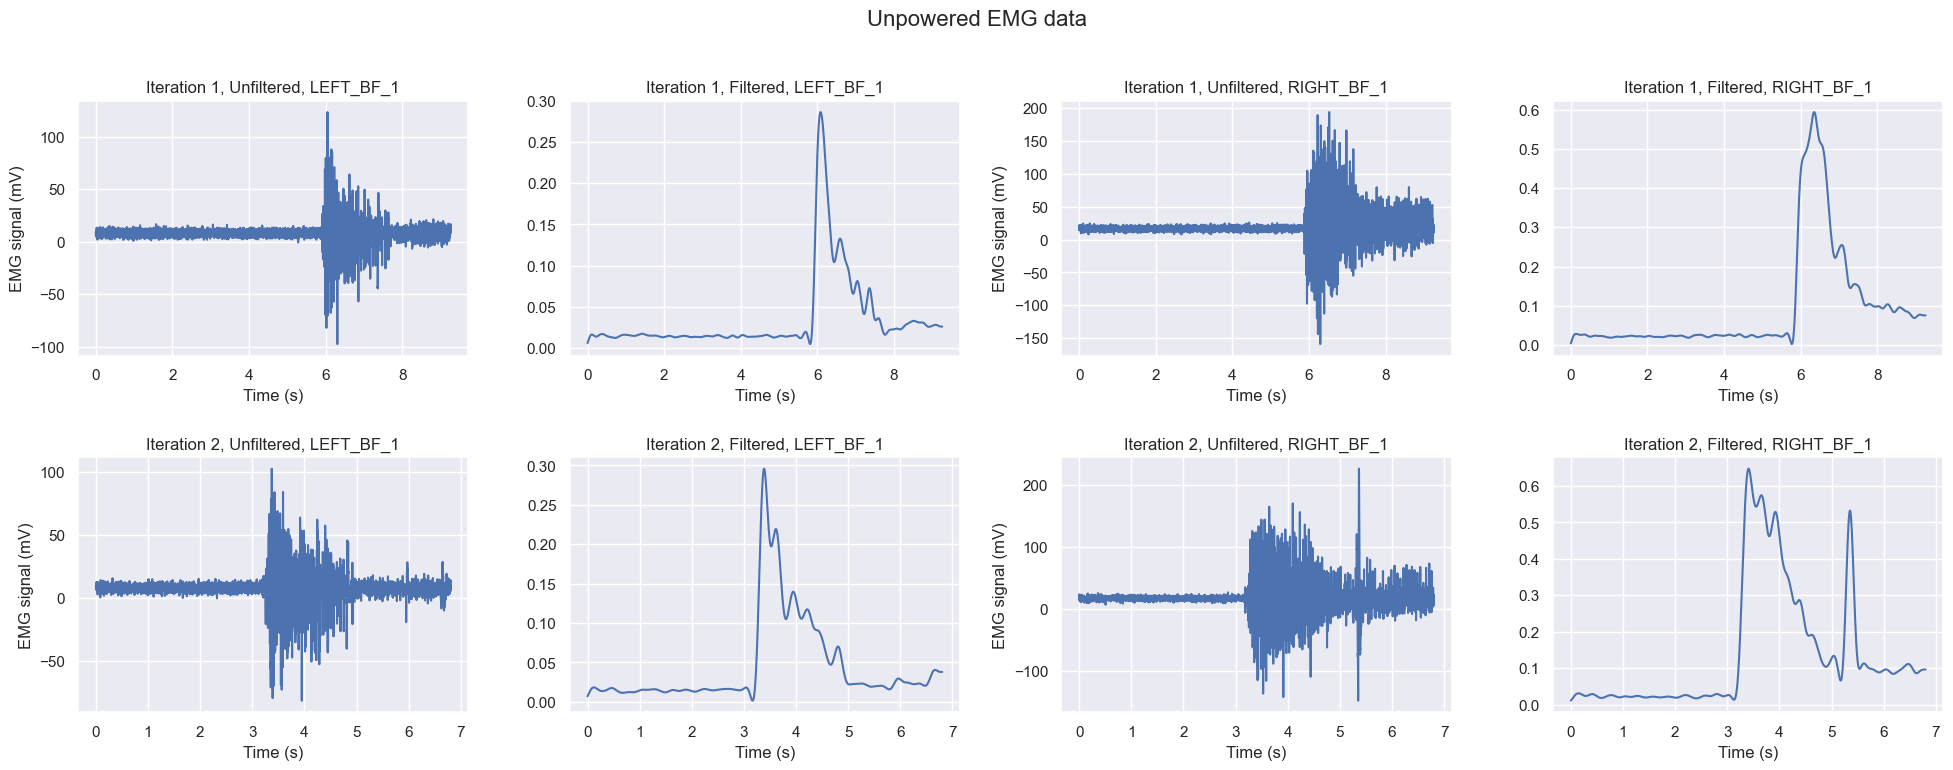

In [13]:
plot_muscle_emg(title="Unpowered EMG data",
                target_muscle="BF_1",
                unfiltered_dfs=session_data["UNPOWERED"]["BEFORE"]["EMG"][:5],
                filtered_dfs=filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"][:5],
                freq=freq)

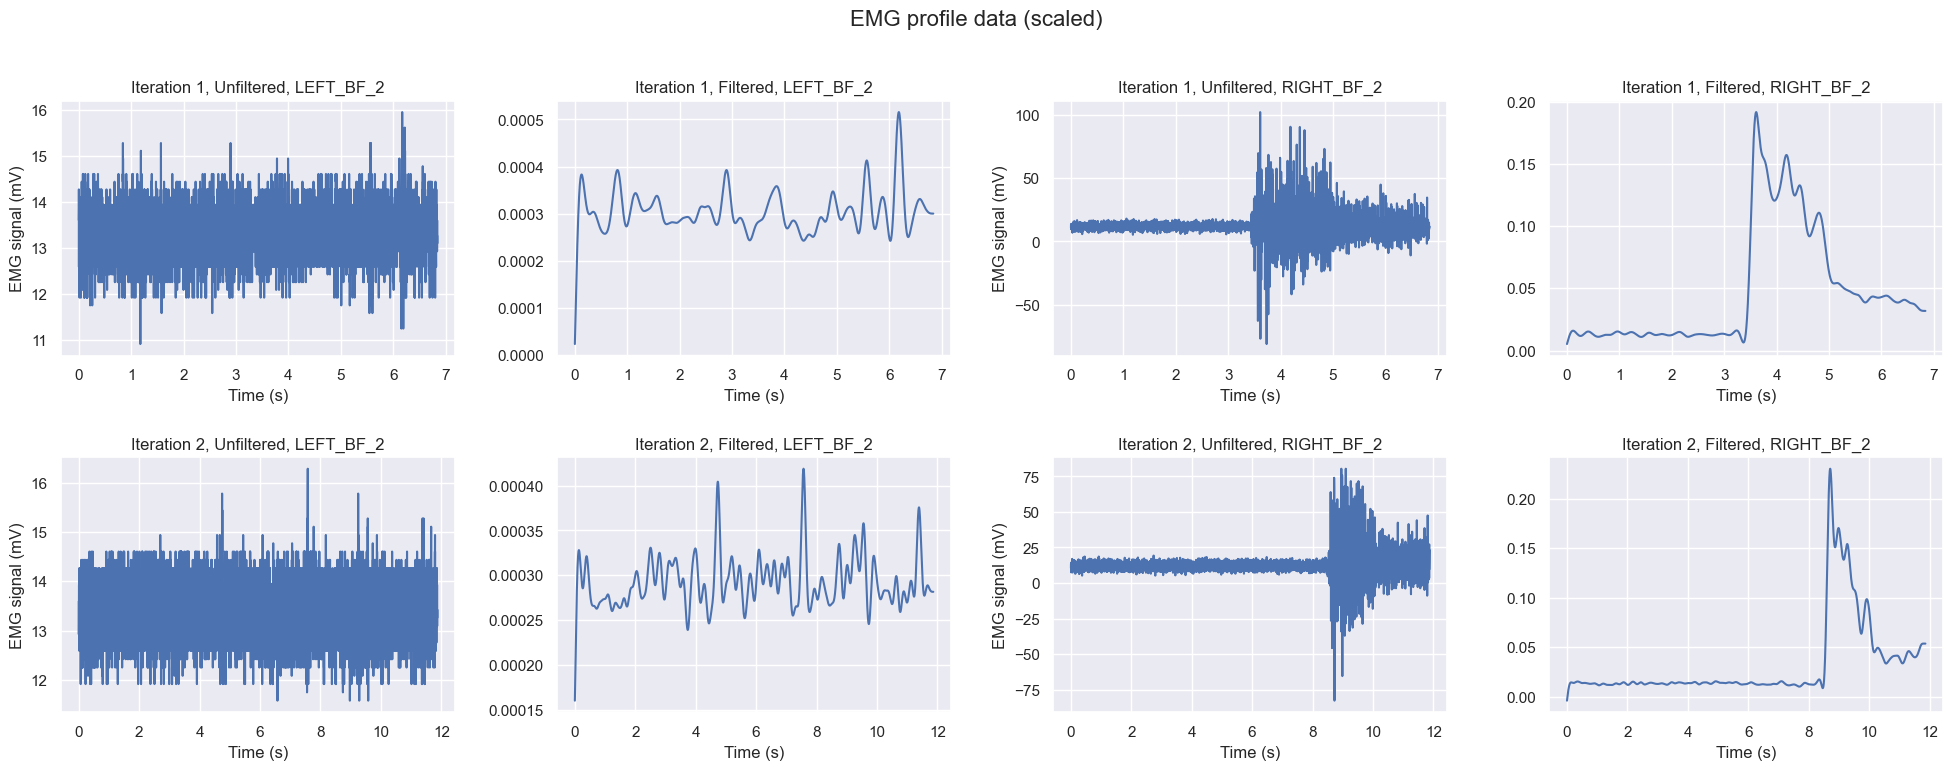

In [28]:
plot_muscle_emg(title="EMG profile data (scaled)",
                target_muscle="BF_2",
         unfiltered_dfs=session_data["ASSISTED"]["peak_27%_62N"]["EMG"],
         filtered_dfs=filtered_session_data["ASSISTED"]["peak_27%_62N"]["EMG"], 
         freq=freq)

Text(0.5, 0, 'time(s)')

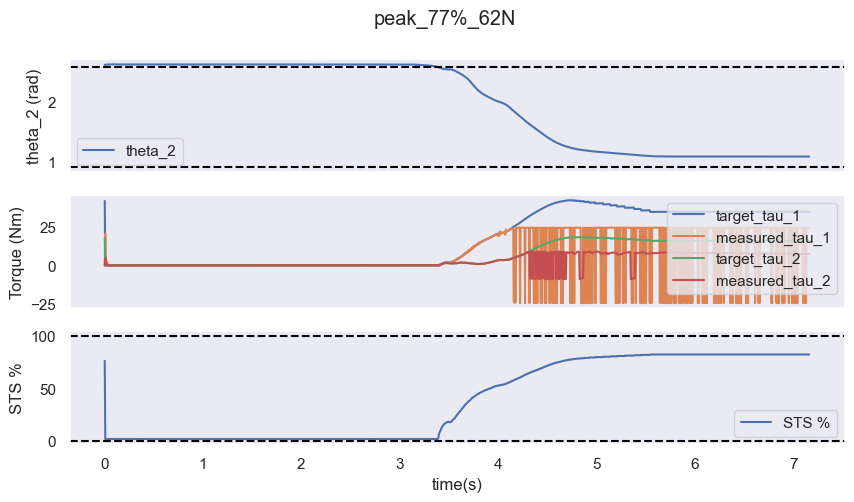

In [15]:
motor_log = filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"][0]

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
fig.suptitle(profile)

ax[0].plot(motor_log.index, motor_log["theta_2"], label="theta_2")
# ax[0].plot(motor_log.index, angle_calibration["theta_2_values"], label="theta_2 at calibration")
ax[0].axhline(y=angle_calibration["new_range"]["min"], linestyle="--", color="black")
ax[0].axhline(y=angle_calibration["new_range"]["max"], linestyle="--", color="black")
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("theta_2 (rad)")


ax[1].plot(motor_log.index, motor_log["target_tau_1"], label="target_tau_1")
ax[1].plot(motor_log.index, motor_log["measured_tau_1"], label="measured_tau_1")
ax[1].plot(motor_log.index, motor_log["target_tau_2"], label="target_tau_2")
ax[1].plot(motor_log.index, motor_log["measured_tau_2"], label="measured_tau_2")
ax[1].grid()
ax[1].legend()
ax[1].set_ylabel("Torque (Nm)")

ax[2].plot(motor_log.index, motor_log["Percentage"], label="STS %")
ax[2].axhline(y=100, linestyle="--", color="black")
ax[2].axhline(y=0, linestyle="--", color="black")
ax[2].grid()
ax[2].legend()
ax[2].set_ylabel("STS %")
ax[2].set_xlabel('time(s)')

### Calculate relevant ranges for UNPOWERED and ASSISTED

In [16]:
time_range = namedtuple("TimeRange", ["min", "max"])

In [17]:
relevant_ranges = {}

for profile in filtered_session_data["ASSISTED"].keys():
    relevant_ranges[profile] = []
    for marker_data in filtered_session_data["ASSISTED"][profile]["MARKER_DATA"]:
        hip_vel = smooth_dataframe(marker_data["Hip Left Z"].diff() / marker_data.index.diff(), window_size=30)

        baseline = hip_vel.loc[:1]
        baseline_avg = baseline.mean() + 0.05 # add offset to be safe

        condition = hip_vel > baseline_avg

        first_index = condition.idxmax() - 0.2
        last_index = condition.iloc[::-1].idxmax() + 0.7

        relevant_ranges[profile].append(time_range(first_index, last_index))

for unpowered_time in filtered_session_data["UNPOWERED"].keys():
    relevant_ranges[f"UNPOWERED_{unpowered_time}"] = []

    for marker_data in filtered_session_data["UNPOWERED"][unpowered_time]["MARKER_DATA"]:
        hip_vel = smooth_dataframe(marker_data["Hip Left Z"].diff() / marker_data.index.diff(), window_size=30)

        baseline = hip_vel.loc[:1]
        baseline_avg = baseline.mean() + 0.05

        condition = hip_vel > baseline_avg

        first_index = condition.idxmax() - 0.2
        last_index = condition.iloc[::-1].idxmax() + 0.7

        relevant_ranges[f"UNPOWERED_{unpowered_time}"].append(time_range(first_index, last_index))


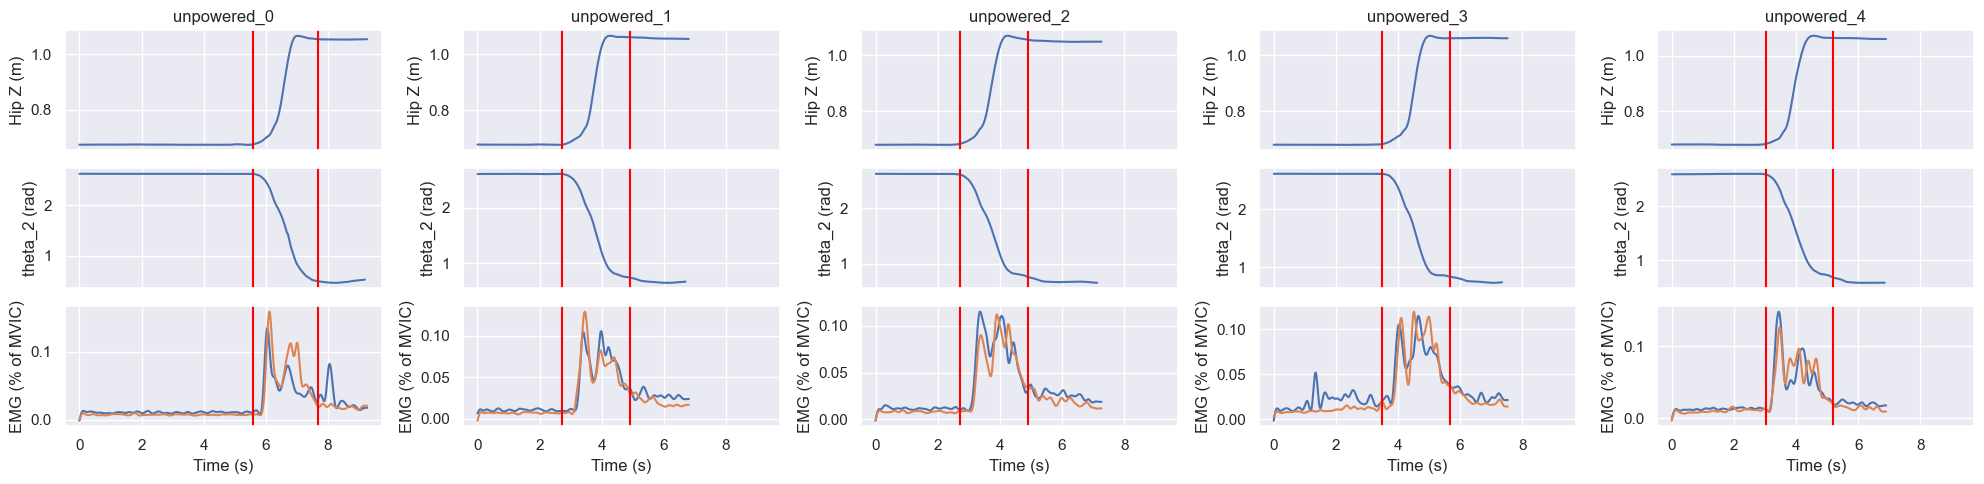

In [18]:
fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, figsize=(20, 5))

t_unpowered = "BEFORE"

for i, t_range in enumerate(relevant_ranges[f"UNPOWERED_{t_unpowered}"]):
    marker_data = filtered_session_data["UNPOWERED"][t_unpowered]["MARKER_DATA"][i] 
    motor_data = filtered_session_data["UNPOWERED"][t_unpowered]["MOTOR_DATA"][i]
    emg_data = filtered_session_data["UNPOWERED"][t_unpowered]["EMG"][i]

    axs[0, i].set_title(f"unpowered_{i}")
    axs[0, i].plot(marker_data.index, marker_data["Hip Left Z"])
    axs[0, i].set_ylabel("Hip Z (m)")
    axs[0, i].axvline(t_range.min, color="red")
    axs[0, i].axvline(t_range.max, color="red")
    axs[0, i].grid(True)

    axs[1, i].plot(motor_data.index, motor_data["theta_2"])
    axs[1, i].set_ylabel("theta_2 (rad)")
    axs[1, i].axvline(t_range.min, color="red")
    axs[1, i].axvline(t_range.max, color="red")
    axs[1, i].grid(True)

    axs[2, i].plot(emg_data.index, emg_data["LEFT_RF"])
    axs[2, i].plot(emg_data.index, emg_data["RIGHT_RF"])
    axs[2, i].set_xlabel("Time (s)")
    axs[2, i].set_ylabel("EMG (% of MVIC)")
    axs[2, i].axvline(t_range.min, color="red")
    axs[2, i].axvline(t_range.max, color="red")
    axs[2, i].grid(True)
plt.tight_layout()

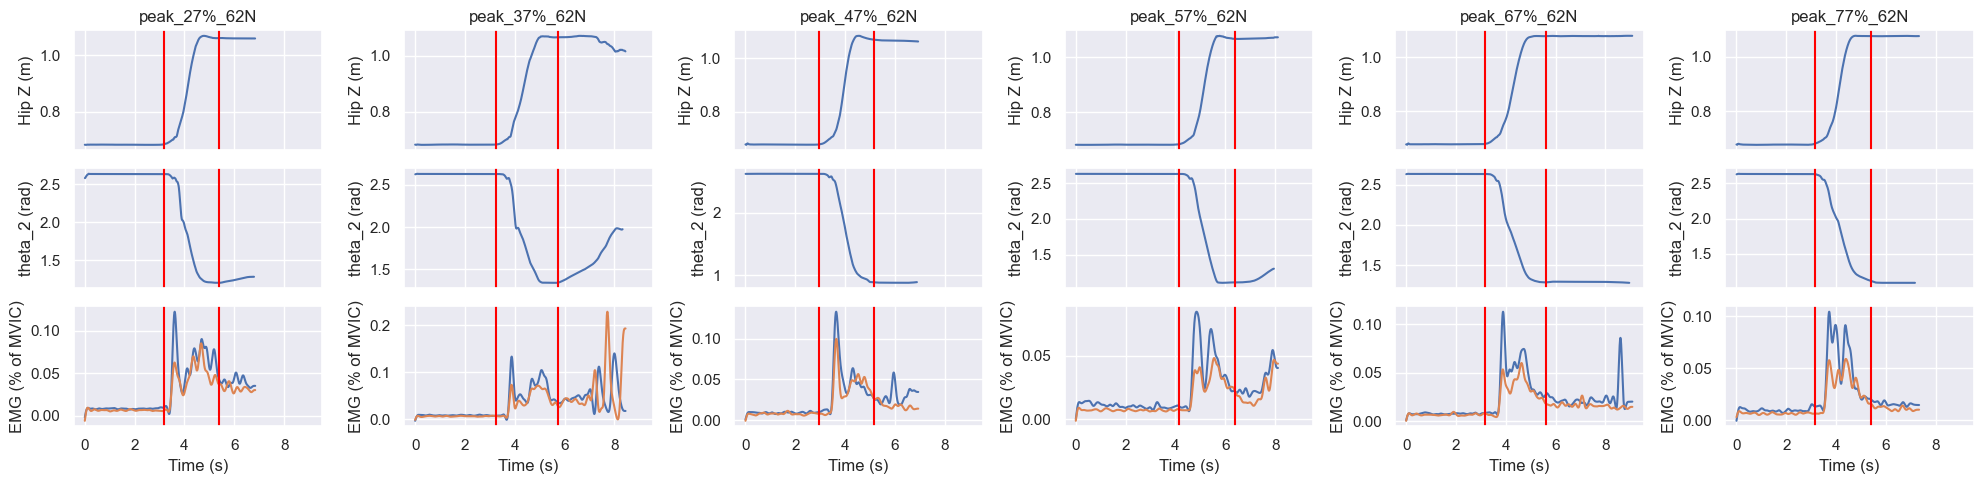

In [19]:
n_prof = len(relevant_ranges.keys()) - 2

fig, axs = plt.subplots(nrows=3, ncols=n_prof, sharex=True, figsize=(20, 5))

for i, (profile, range_list) in enumerate(relevant_ranges.items()):
    if profile.startswith("UNPOWERED"):
        continue
    rel_range = range_list[0] # Get first iteration range

    marker_data = filtered_session_data["ASSISTED"][profile]["MARKER_DATA"][0] 
    motor_data = filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"][0]
    emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][0]
    
    axs[0, i].set_title(profile)
    axs[0, i].plot(marker_data.index, marker_data["Hip Left Z"])
    axs[0, i].set_ylabel("Hip Z (m)")
    axs[0, i].axvline(rel_range.min, color="red")
    axs[0, i].axvline(rel_range.max, color="red")
    axs[0, i].grid(True)

    axs[1, i].plot(motor_data.index, motor_data["theta_2"])
    axs[1, i].set_ylabel("theta_2 (rad)")
    axs[1, i].axvline(rel_range.min, color="red")
    axs[1, i].axvline(rel_range.max, color="red")
    axs[1, i].grid(True)

    axs[2, i].plot(emg_data.index, emg_data["LEFT_RF"])
    axs[2, i].plot(emg_data.index, emg_data["RIGHT_RF"])
    axs[2, i].set_xlabel("Time (s)")
    axs[2, i].set_ylabel("EMG (% of MVIC)")
    axs[2, i].axvline(rel_range.min, color="red")
    axs[2, i].axvline(rel_range.max, color="red")
    axs[2, i].grid(True)
plt.tight_layout()

## Mean baseline activations for every muscle

## Unpowered activations

In [20]:
unpowered_dfs = filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"]
cut_off_dfs = {"ASSISTED": dict(), "UNPOWERED": dict()}

for profile in filtered_session_data["ASSISTED"].keys():
    rel_ranges = relevant_ranges[profile] # Get first iteration range
    cut_off_dfs["ASSISTED"][profile] = deepcopy(data_dict)

    emg_dfs, motor_dfs, marker_dfs = filtered_session_data["ASSISTED"][profile].values()

    cut_off_dfs["ASSISTED"][profile]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
    cut_off_dfs["ASSISTED"][profile]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
    cut_off_dfs["ASSISTED"][profile]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]

for t_unpowered in filtered_session_data["UNPOWERED"].keys():
    rel_ranges = relevant_ranges[f"UNPOWERED_{t_unpowered}"] # Get first iteration range

    cut_off_dfs["UNPOWERED"][t_unpowered] = deepcopy(data_dict)

    emg_dfs, motor_dfs, marker_dfs = filtered_session_data["UNPOWERED"][t_unpowered].values()

    cut_off_dfs["UNPOWERED"][t_unpowered]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
    cut_off_dfs["UNPOWERED"][t_unpowered]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
    cut_off_dfs["UNPOWERED"][t_unpowered]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]


### Calculate mean activation

In [21]:
# Calculate mean EMG values for each muscle (before and after trials)
# Concatenate all EMG dataframes into one dataframe for each muscle, and calculate mean
emg_means_before = pd.concat(cut_off_dfs["UNPOWERED"]["BEFORE"]["EMG"]).mean()
emg_means_after = pd.concat(cut_off_dfs["UNPOWERED"]["AFTER"]["EMG"]).mean()

### Calculate peak activation

In [22]:
# Calculate peak EMG values for each muscle (before and after trials)
max_values_before = pd.DataFrame([df.max() for df in cut_off_dfs["UNPOWERED"]["BEFORE"]["EMG"]])
max_values_after = pd.DataFrame([df.max() for df in cut_off_dfs["UNPOWERED"]["AFTER"]["EMG"]])

peak_emg_means_before = max_values_before.mean()
peak_emg_means_after = max_values_after.mean()

In [23]:
activation_deltas = {}

for profile, data in cut_off_dfs["ASSISTED"].items():
    emg_data = data["EMG"]
    activation_deltas[profile] = {"MEAN": [], "PEAK_DIFF": [], "STD_MEAN": [], "STD_PEAK": []}

    for emg_df in emg_data:
        mean_diff = (emg_df.mean() - emg_means_before) / emg_means_before * 100
        peak_diff = (emg_df.max() - peak_emg_means_before) / peak_emg_means_before * 100

        activation_deltas[profile]["MEAN"].append(mean_diff)
        activation_deltas[profile]["PEAK_DIFF"].append(peak_diff)
        activation_deltas[profile]["STD_MEAN"].append(emg_df.std())
        activation_deltas[profile]["STD_PEAK"].append(emg_df.max())

NameError: name 'plot_df' is not defined

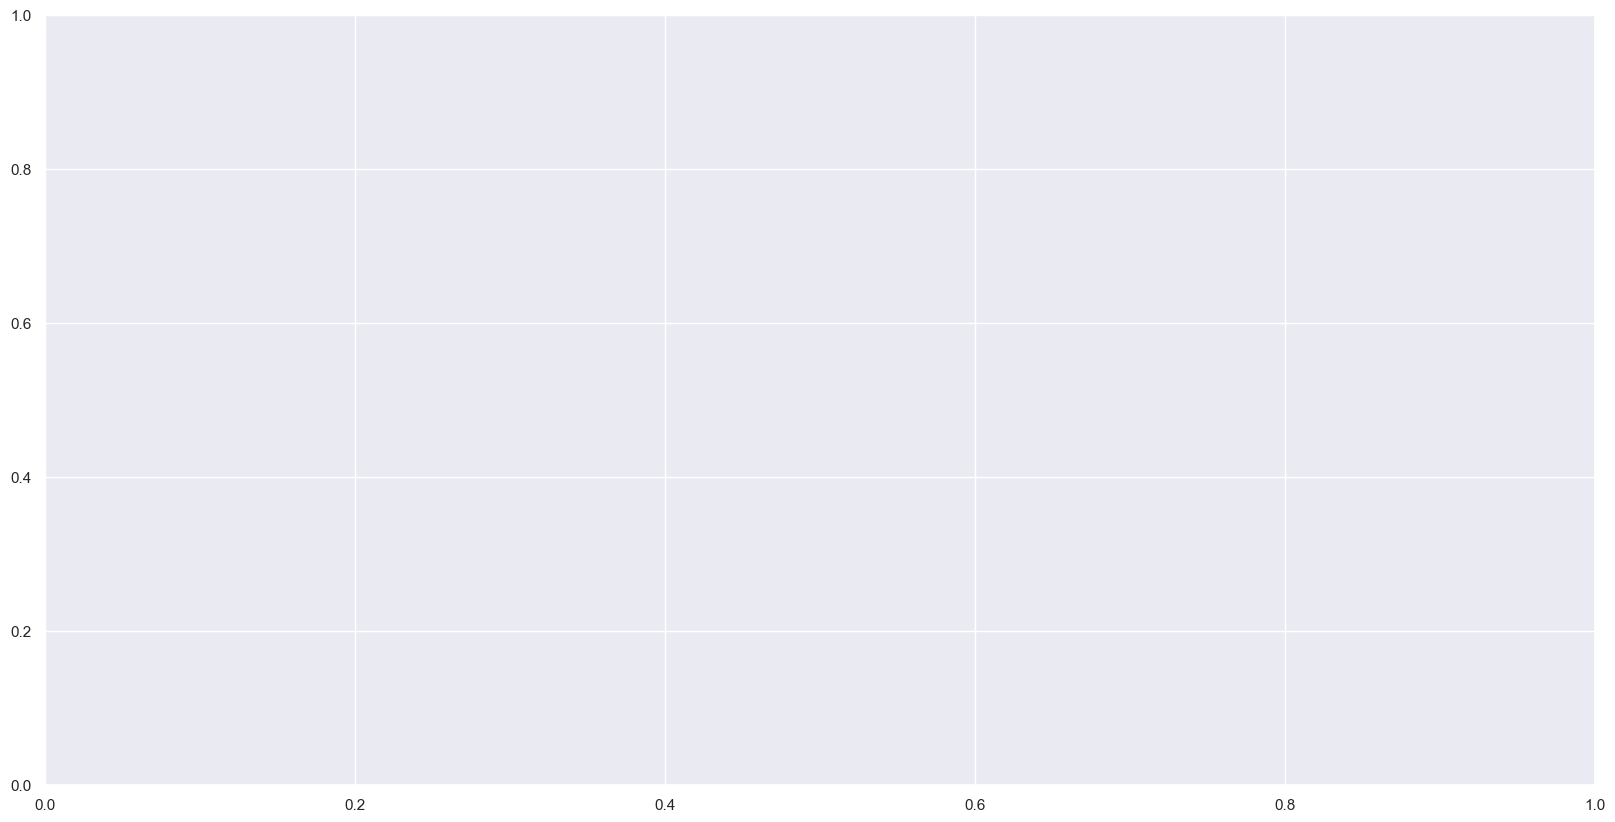

In [24]:
# my_colors = ["#9db5dc", "#FF8E8A", "#a2cf97", "#6992BB", "#D7554F", "#83BD76", "#3d6e9b", "#8F1F1B", "#5e914f"]

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=plot_df, x='Muscle', y='Mean', hue='Profile', ax=ax)
sns.stripplot(data=plot_df, x='Muscle', y='Mean', hue='Profile', size = 4, dodge = True, jitter = False, facecolor = 'black', edgecolor = 'black', linewidth= 1)

current_palette = sns.color_palette()

handles, labels = ax.get_legend_handles_labels()

num_profiles = len(plot_df['Profile'].unique())
bar_handles = handles[:num_profiles]
bar_labels = labels[:num_profiles]


for i, bar in enumerate(ax.patches):
    bar.set_edgecolor('black')

strip_collections = ax.collections

for collection, color in zip(strip_collections, current_palette):
    collection.set_edgecolor('black')

# ax.get_legend().remove()
from matplotlib.patches import Patch

ax.legend(bar_handles, bar_labels)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.title('Mean and Standard Deviation of EMG Data per Muscle across Profiles')
plt.xlabel('Muscle')
plt.ylabel('EMG Value')

ax
